# MLB Data Analysis - Player Demographics and Career Lengths

Data from https://www.kaggle.com/seanlahman/the-history-of-baseball, accessed 6/17/20

##### Import libraries and data

In [1]:
import pandas as pd
import numpy as np

import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math

import warnings 
warnings.filterwarnings ("ignore")

In [2]:
data = {}
for d in glob.glob('*.csv'):
    data[d.split('.')[0]] = pd.read_csv(d)

In [3]:
data.keys()

dict_keys(['all_star', 'appearances', 'batting', 'batting_postseason', 'college', 'fielding', 'fielding_outfield', 'fielding_postseason', 'hall_of_fame', 'home_game', 'manager', 'manager_award', 'manager_award_vote', 'manager_half', 'park', 'pitching', 'pitching_postseason', 'player', 'player_award', 'player_award_vote', 'player_college', 'postseason', 'salary', 'team', 'team_franchise', 'team_half'])

# Analysis

### Dataset overview

In [4]:
# Timeframe of data
team = data['team']
print("Games in dataset were played between {} and {}.".format(team['year'].min(), team['year'].max()))

# Number of players
pl = data['player']
print("Data collected was from {} players, born between years {} and {}.".format(len(pl), int(pl[pl['birth_year']>0]['birth_year'].min()), int(pl['birth_year'].max())))


Games in dataset were played between 1871 and 2015.
Data collected was from 18846 players, born between years 1820 and 1995.


In [5]:
bat = data['batting']
leagues = bat['league_id'].unique()
print("Major Leagues:")
for l in leagues:
    if pd.notna(l):
        print("{}: Formed in {}; Most recent year {}".format(l, bat[bat['league_id']==l]['year'].min(), bat[bat['league_id']==l]['year'].max()))

Major Leagues:
NL: Formed in 1876; Most recent year 2015
AA: Formed in 1882; Most recent year 1891
UA: Formed in 1884; Most recent year 1884
PL: Formed in 1890; Most recent year 1890
AL: Formed in 1901; Most recent year 2015
FL: Formed in 1914; Most recent year 1915


This dataset contains data dating from 1871 until 2015.

While 6 different major leagues have existed, most existed for only one or a few seasons in the late 1800s and early 1900s. Of the two leagues still in existence today, the National League was founded in 1876, and the American League in 1901.

According to https://www.history.com/this-day-in-history/national-league-of-baseball-is-founded, major league baseball was established in the US when the National Association of Professional Base Ball Players was founded in 1871. This was two years after the United States' first professional baseball team, the Cincinnati Red Stockings, was formed.

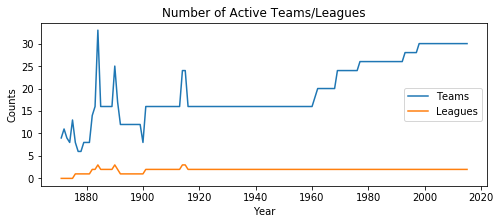

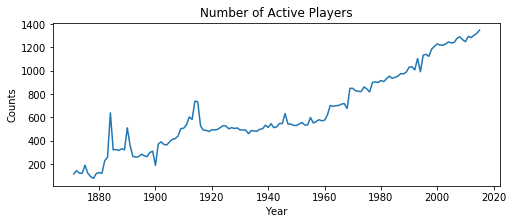

In [6]:
# Number of leagues and teams
fig = plt.figure(figsize=(8,3))
plt.plot(team.groupby(team['year']).count()['team_id'], label="Teams")
plt.plot(team.groupby(team['year']).nunique()['league_id'], label = "Leagues")
plt.title("Number of Active Teams/Leagues")
plt.legend()
plt.xlabel('Year')
plt.ylabel('Counts')
plt.show()

# Number of active players
fig = plt.figure(figsize=(8,3))
plt.plot(bat.groupby(bat['year']).nunique()['player_id'], label = "Players")
plt.title("Number of Active Players")
plt.xlabel('Year')
plt.ylabel('Counts')

plt.show()

We can see that the number of teams fluctuated a lot in the early years of American baseball. Leagues were created at the same time as a spike in the number of teams, and these often existed for a single year. It could be that a group of existing teams were incorporated into the "major leagues" for a season. With the exception of 1914-15, there was little change from 1901 until the 1960s, when the number of teams began to grow.

We see a similar pattern in the number of players over the years. There are peaks in the number of players at the same times as there are spikes in the number of teams. Additionally, the number of players in a year has been growing since the 1960s. While the number of teams has been static since about 2000, the number of players has continued to grow.

### Player Analysis

##### Birth Year

In [7]:
# Birth years and countries - Prep data
loc = pl[pd.notna(pl['birth_year'])][['player_id', 'birth_year', 'birth_country', 'birth_state']].reindex()
loc = loc[pd.notna(loc['birth_country'])]
loc = loc[loc['birth_year']>0] # Some missing values are 0 instead of NaN
loc['birth_decade'] = [math.floor(year/10)*10 for year in loc['birth_year']] # Bin years into decades

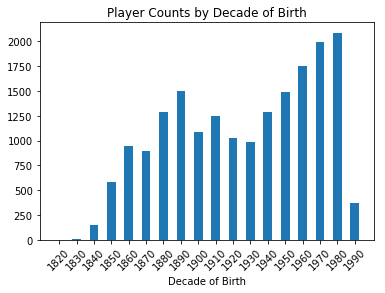

In [8]:
X = sorted(loc['birth_decade'].unique())
Y = loc.groupby('birth_decade').count()['player_id']
plt.bar(x=X, height=Y, width=5)
plt.xticks(ticks=loc['birth_decade'].unique(),rotation=45)
plt.title('Player Counts by Decade of Birth')
plt.xlabel('Decade of Birth')
plt.show()

It makes sense that very few players were born before 1840, as they would be 30 to 50 years old at the time of the Association's founding in 1871.

The number of players born through the 1890s pretty steadily increases; however, there is a sudden drop at 1900 until the numbers begin to increase again with players born in 1940. **This is likely because of the World Wars and the Great Depression. Many men coming of age around 1917 would have enlisted or been drafted into the army, and likewise with men coming of age around 1941.** It is possible that the spike at 1910 occurred because men born during this decade would have come of age between the two wars.

Given that the youngest person in the dataset was born in 1995, and the games data goes until 2015, **age 20 is probably the youngest a player can usually get into the major leagues.** The small number of players born in the 90s brings up the question of how old players are, on average, when they make their major leage debut. Are we really looking at players born before 1993, who in 2015 would have been at least 23, with a few young superstars?

##### Player Ages

In [9]:
pl_age = pl[['player_id', 'birth_year']].merge(bat[['player_id', 'year']], how='outer', left_on='player_id', right_on='player_id')
pl_age = pl_age[pd.notna(pl_age['year'])]
pl_age['age'] = pl_age['year'] - pl_age['birth_year']
pl_age['decade'] = [math.floor(year/10)*10 for year in pl_age['year']]
pl_age.drop(pl_age[pl_age['age']<15].index, inplace=True)

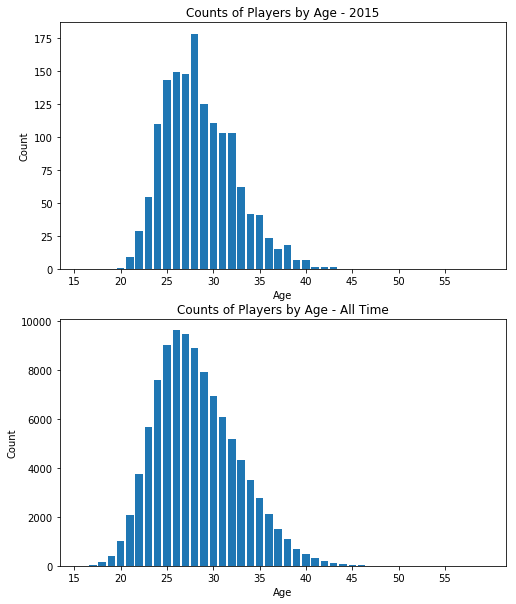

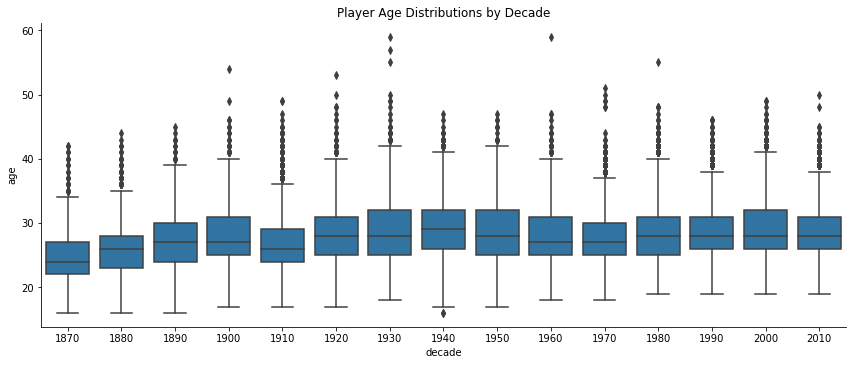

569 out of 101327 players (0.6%) were under 20
In 2015, 39 out of 1486 players (2.6%) were under 23


In [10]:
min_age = math.floor(min(pl_age['age'].unique())/10)*10+5
max_age = math.ceil(max(pl_age['age'].unique())/10)*10

fig = plt.figure(figsize=(8,10))

ax1 = fig.add_subplot(212)
plt.subplot(2,1,2)
plt.bar(pl_age.groupby('age').count()['player_id'].index, height=pl_age.groupby('age').count()['player_id'])
plt.xticks([min_age + 5*i for i in range(int((max_age-min_age)/5))])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Counts of Players by Age - All Time')

ax2 = plt.subplot(211, sharex=ax1)
plt.bar(pl_age[pl_age['year']==2015].groupby('age').count()['player_id'].index, height=pl_age[pl_age['year']==2015].groupby('age').count()['player_id'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Counts of Players by Age - 2015')
plt.show()

box = sns.catplot(data=pl_age, x='decade', y='age', kind='box', height=5, aspect=12/5, color='tab:blue')
plt.title('Player Age Distributions by Decade')
plt.show()

under20 = len(pl_age[pl_age['age']<20])
all_pl = len(pl_age)
print("{} out of {} players ({}%) were under 20".format(under20, all_pl, round(100*under20/all_pl, 1)))

under23_2015 = len(pl_age[(pl_age['year']==2015) & (pl_age['age']<23)])
all_pl_2015 = len(pl_age[pl_age['year']==2015])
print("In 2015, {} out of {} players ({}%) were under 23".format(under23_2015, all_pl_2015, round(100*under23_2015/all_pl_2015, 1)))

We were correct in our guess that most of the players playing in 2015 were at least 23 years old. MLB player age distribution is slightly right-tailed but has remained fairly constant throughout the history of American baseball.

##### Birthplace

In [11]:
# Add "American" column (American-born=1, foreign=0)
loc['American'] = [1 if bc=='USA' else 0 for bc in loc['birth_country']]
#loc.head()

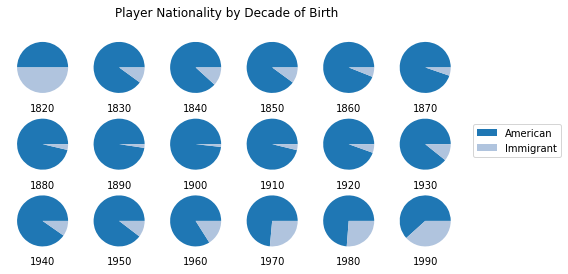

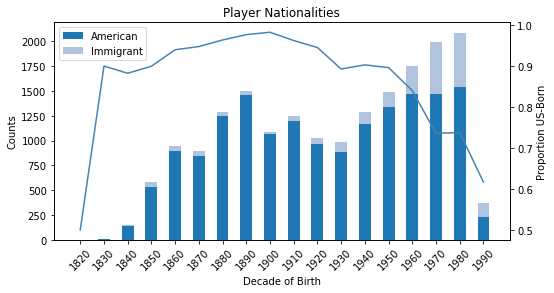

In [12]:
# Pie plots showing ratio of American to foreign-born players
fig2 = plt.figure(figsize=(8,4))

for i in range(18):
    plt.subplot(3,6,i+1)
    plt.pie(loc[loc['birth_decade']==1820+(10*i)]['American'].value_counts(), labels=None, colors=[None, 'lightsteelblue'])
    plt.xlabel(str(1820+(10*i)))

plt.suptitle("Player Nationality by Decade of Birth")
plt.legend(['American', 'Immigrant'], loc=(1.25,1.5))
plt.show()

################################

fig = plt.figure(figsize=(18,4))

# Stacked bar chart of American & Immigrant players
ax1 = fig.add_subplot(121)
plt.subplot(1,2,1)
X = sorted(loc['birth_decade'].unique())
Y1 = loc.groupby('birth_decade').sum()['American']
Y2 = loc.groupby('birth_decade').count()['American'] - loc.groupby('birth_decade').sum()['American']
plt.bar(x=X, height=Y1,width=5)
plt.bar(x=X, height=Y2, bottom = Y1,width=5, color='lightsteelblue')
plt.xticks(ticks=loc['birth_decade'].unique(),rotation=45)
plt.legend(['American', 'Immigrant'])
plt.xlabel('Decade of Birth')
plt.ylabel('Counts')
plt.title('Player Nationalities')

# Line chart of proportion of players American-born
ax2 = ax1.twinx()
plt.plot(loc.groupby('birth_decade').mean()['American'], label='proportion US-born', color='steelblue')
plt.xlabel('Decade of Birth')
plt.ylabel('Proportion US-Born')

plt.show()

The proportion of ballplayers born in the US increased through 1900, peaking at about 98%. Since then, a growing percentage of players have immigrated to the US. About 25% of players born in the 1980s immigrated. Interestingly, although the number of players has been increasing since the 1930s generation, the actual number of American-born players born in the 1980s is similar to the number born 90 years before.

**The number of immigrant players is growing. Where are they coming from?**

In [13]:
# Make dataframe of total players by birth country and decade of birth
dec = {}
countries = list(loc['birth_country'].value_counts().index[1:]) # countries of origin - most to least players, sans U.S.A.
                   
for i in range(len(countries)):
    dec[countries[i]] = dict(loc[loc['birth_country']==countries[i]].groupby('birth_decade').count()['player_id'])
    
df = pd.DataFrame(dec)
df = df.fillna(0).transpose()

df['Total'] = [df.iloc[i].sum() for i in range(len(df))]
other = pd.Series(df.loc['Australia':].sum(), name='Other')
df2 = df.loc[:'Germany'].append(other).drop('Total', axis=1)

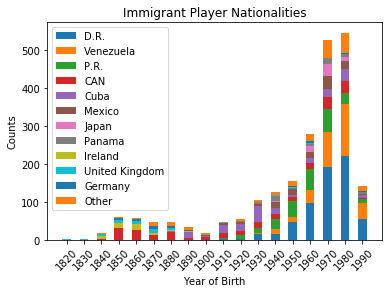

In [14]:
# Stacked bar chart of immigrant players according to decade and country of birth
X = sorted(loc['birth_decade'].unique()) # x-axis: decades of birth
arr = df2.iloc[0]
plt.bar(x=X, height=arr,width=5)

for i in range(len(df2)-1):
    Y = df2.iloc[i+1]
    plt.bar(x=X, height=Y, bottom=arr, width=5)
    arr = arr + Y

plt.xticks(ticks=loc['birth_decade'].unique(),rotation=45)
plt.xlabel('Year of Birth')
plt.ylabel('Counts')
plt.title('Immigrant Player Nationalities')
plt.legend(countries[:len(df2)-1]+['Other'])
plt.show()

Foreign ballplayers born in the 1800s were mainly from Canada, Ireland, and the U.K. In the early 1900s, Cuba, Puerto Rico, and the Dominican Republic began to be represented, quickly forming the majority of immigrant ballplayers. The majority of immigrant players born in the 1970s or later are from the Dominican Republic or Venezuela. The number of players born in Puerto Rico peaked around 1960 and has since been decreasing.

**Most of the recent immigrants are from Latin America.** The main exception is Japan. Since the 1960s a significant number of players have been born in Japan.

##### Player Debut/Retirement

In [15]:
pl_yrs_played = pl[pl['birth_year']>0][['player_id', 'birth_year', 'debut', 'final_game']]
pl_yrs_played = pl_yrs_played[pd.notna(pl_yrs_played['debut'])]#.reindex() # removes all NaNs in debut & final game cols

# Convert 'debut' and 'final game' columns to datetime
pl_yrs_played['debut'] = pd.to_datetime(pl_yrs_played['debut'], yearfirst=True)
pl_yrs_played['final_game'] = pd.to_datetime(pl_yrs_played['final_game'], yearfirst=True)

# Extract years the players debuted and retired
pl_yrs_played['debut_year'] = pl_yrs_played['debut'].dt.year
pl_yrs_played['final_year'] = pl_yrs_played['final_game'].dt.year
pl_yrs_played['debut_decade'] = [math.floor(year/10)*10 for year in pl_yrs_played['debut_year']]
pl_yrs_played['final_decade'] = [math.floor(year/10)*10 for year in pl_yrs_played['final_year']]

# Compute ages at which the players debuted and retired
pl_yrs_played['debut_age'] = pl_yrs_played['debut_year'] - pl_yrs_played['birth_year']
pl_yrs_played['retired?'] = (pl_yrs_played['final_year']!=2015).astype(int)
pl_yrs_played['retire_age'] = [(pl_yrs_played.iloc[i]['final_year'] - pl_yrs_played.iloc[i]['birth_year']) if pl_yrs_played.iloc[i]['final_year']!=2015 else -1 for i in range(len(pl_yrs_played))]

# Extract the number of seasons played
pl_yrs_played['years_played'] = 1 + pl_yrs_played['final_year'] - pl_yrs_played['debut_year']

# Remove bad data
pl_yrs_played.drop(pl_yrs_played[pl_yrs_played['debut_age']<0].index, inplace=True)

In [16]:
print("Average age of debut: ", round(pl_yrs_played['debut_age'].mean()))
print("Average age of retirement: ", round(pl_yrs_played[pl_yrs_played['retire_age']>0]['retire_age'].mean()))

Average age of debut:  24
Average age of retirement:  29


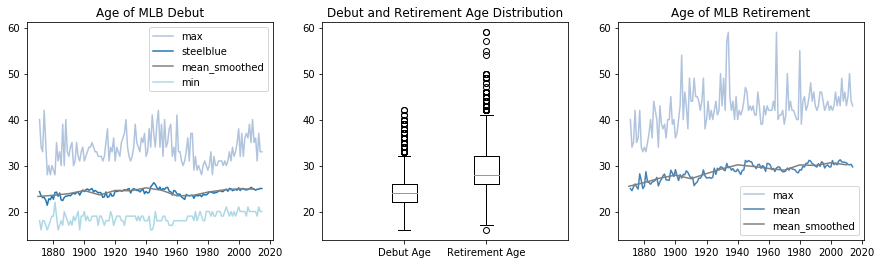

In [17]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
plt.plot(pl_yrs_played.groupby('debut_year').max()['debut_age'], label='max', color='lightsteelblue')
plt.plot(pl_yrs_played.groupby('debut_year').mean()['debut_age'], label='steelblue')
plt.plot(pl_yrs_played.groupby('debut_decade').mean()['debut_age'], label='mean_smoothed', color='grey')
plt.plot(pl_yrs_played.groupby('debut_year').min()['debut_age'], label='min', color='lightblue')
plt.legend()
plt.title("Age of MLB Debut")

ax2 = fig.add_subplot(132, sharey=ax1)
plt.boxplot(x=[pl_yrs_played['debut_age'], pl_yrs_played[pl_yrs_played['retire_age']>0]['retire_age']],
            labels=['Debut Age', 'Retirement Age'], positions=[0.5,1])
plt.title("Debut and Retirement Age Distribution")

ax3 = fig.add_subplot(133, sharey=ax1)
plt.plot(pl_yrs_played[pl_yrs_played['retired?']==1].groupby('final_year').max()['retire_age'], label='max', color='lightsteelblue')
plt.plot(pl_yrs_played[pl_yrs_played['retired?']==1].groupby('final_year').mean()['retire_age'], label='mean', color='steelblue')
plt.plot(pl_yrs_played[pl_yrs_played['retired?']==1].groupby('final_decade').mean()['retire_age'], label='mean_smoothed', color='grey')
plt.legend()
plt.title("Age of MLB Retirement")

plt.show()

The average age of a player on entering the major leagues has remained pretty constant at 24 over the past 135 years. Surprisingly, in many years, the oldest new major leaguer was over 35 years old. Until 1960, there would occasionally be a 16-year-old in the major leagues. Since after 1960, all players are at least 18 years of age, presumably the laws changed at that time. Since 1979, all players have been at least 19 years old.

MLB retirement age has slowly been increasing. While the overall average age of leaving the major leagues is 29, there is a slight but noticeable upward trend. **Is this due to players having longer careers?**

##### Career Length

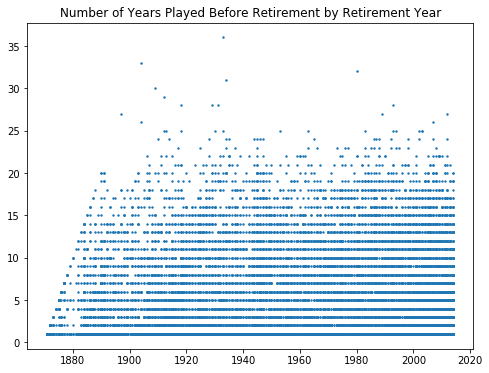

In [18]:
fig = plt.figure(figsize=(8,6))
plt.scatter(pl_yrs_played[pl_yrs_played['retired?']==True]['final_year'], pl_yrs_played[pl_yrs_played['retired?']==True]['years_played'], s=2)
plt.title("Number of Years Played Before Retirement by Retirement Year")
plt.show()

There does seem to be an upward trend in career length. It has gotten more common that in any given year there will be a retiree who has played for at least 15 years. However, a handful of men, mostly retired before 1940, played for more than 25 years.

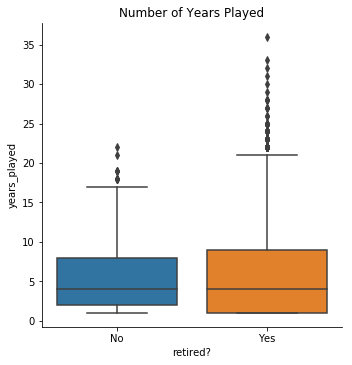

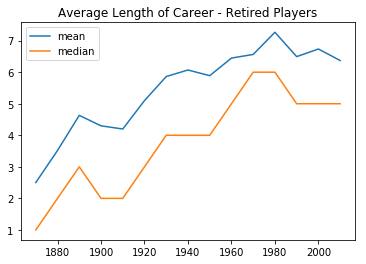

Mean number of years played - active players:  5.21
Median number of years played - active players:  4.0


In [19]:
sns.catplot(x='retired?', y='years_played', data=pl_yrs_played, kind='box')
plt.title("Number of Years Played")
plt.xticks(ticks=[False,True], labels=['No', 'Yes'])
plt.show()

plt.plot(pl_yrs_played[pl_yrs_played['final_year']<2015].groupby('final_decade').mean()['years_played'], label='mean')
plt.plot(pl_yrs_played[pl_yrs_played['final_year']<2015].groupby('final_decade').median()['years_played'], label='median')
plt.legend()
plt.title("Average Length of Career - Retired Players")
plt.show()

print("Mean number of years played - active players: ", round(pl_yrs_played[pl_yrs_played['final_year']==2015].mean()['years_played'],2))
print("Median number of years played - active players: ", pl_yrs_played[pl_yrs_played['final_year']==2015].median()['years_played'])

As the boxplot shows, both retired and currently active players have played for a median 4 years. The line plot shows that career length increased until 1980, peaking at about 7 years. Our assumption seems correct: players retire after a longer career, and since the debut age has remained about the same throughout history, a longer career means that retirement occurs at an older age.

**However, our results could be somewhat skewed by players quitting after just one or two years.** Let's find out.

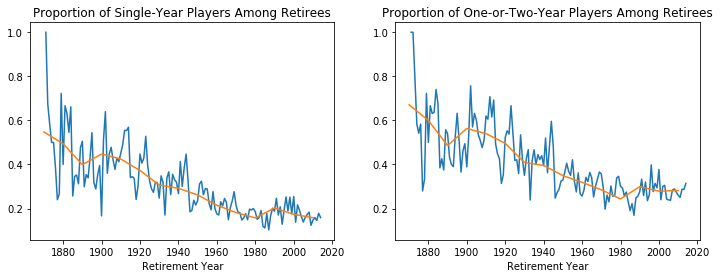

In [21]:
pl_yrs_played['single_year?'] = (pl_yrs_played['years_played']==1).astype(int)
pl_yrs_played['<=2_years'] = (pl_yrs_played['years_played']<=2).astype(int)

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
plt.plot(pl_yrs_played[pl_yrs_played['final_year']<2015].groupby('final_year').mean()['single_year?'])
plt.plot(pl_yrs_played[pl_yrs_played['final_year']<2015].groupby('final_decade').mean()['single_year?'])
plt.xlabel("Retirement Year")
plt.title("Proportion of Single-Year Players Among Retirees")
#plt.show()

ax2 = plt.subplot(1,2,2, sharey=ax1)
plt.plot(pl_yrs_played[pl_yrs_played['final_year']<2015].groupby('final_year').mean()['<=2_years'])
plt.plot(pl_yrs_played[pl_yrs_played['final_year']<2015].groupby('final_decade').mean()['<=2_years'])
plt.xlabel("Retirement Year")
plt.title("Proportion of One-or-Two-Year Players Among Retirees")
plt.show()

Since about 1960, nearly 20% of players quitting or retiring in a given near played for only that one season. Prior to 1960, the proportion was much higher, even up to more than 50% of players retirees retiring after a single year. Since about 1960, 70% of retirees have played for at least 3 years.

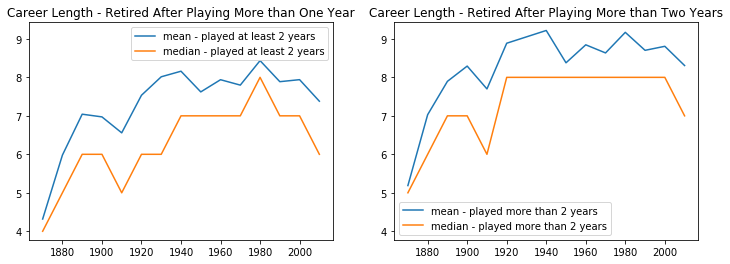

In [22]:
fig,ax =  plt.subplots(1,2, figsize=(12,4))

ax[0].plot(pl_yrs_played[(pl_yrs_played['final_year']<2015) & (pl_yrs_played['years_played']>=2)].groupby('final_decade').mean()['years_played'], label='mean - played at least 2 years')
ax[0].plot(pl_yrs_played[(pl_yrs_played['final_year']<2015) & (pl_yrs_played['years_played']>=2)].groupby('final_decade').median()['years_played'], label='median - played at least 2 years')
ax[0].legend()
ax[0].set_title("Career Length - Retired After Playing More than One Year")

ax[1].plot(pl_yrs_played[(pl_yrs_played['final_year']<2015) & (pl_yrs_played['years_played']>2)].groupby('final_decade').mean()['years_played'], label='mean - played more than 2 years')
ax[1].plot(pl_yrs_played[(pl_yrs_played['final_year']<2015) & (pl_yrs_played['years_played']>2)].groupby('final_decade').median()['years_played'], label='median - played more than 2 years')
ax[1].legend()
ax[1].set_title("Career Length - Retired After Playing More than Two Years")

ymin, ymax = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
plt.setp(ax, ylim=(ymin, ymax))

plt.show()

Once we remove players who played for only a year or two, we find that there has been less of an increase in career length than it seemed. Among players who remained in the major leagues for more than two years, the median career length remained constant at 8 years from 1920 until 2000. **What has changed, however, is that fewer players are quitting after a very short time.** Players who make it past their first or second year play 7-9 years on average in professional baseball.

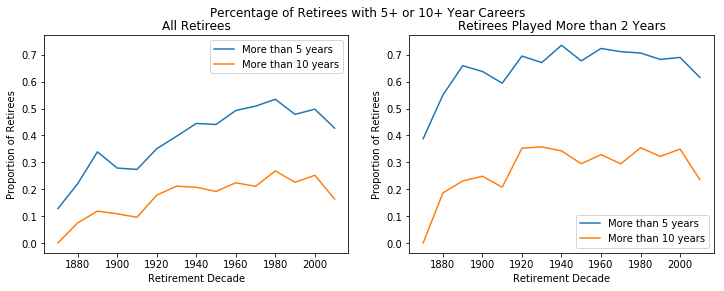

In [23]:
# % of players playing at least 5 years? 10 years?
pl_yrs_played['>5_years'] = (pl_yrs_played['years_played'] > 5).astype(int)
pl_yrs_played['>10_years'] = (pl_yrs_played['years_played'] > 10).astype(int)

fig, ax =  plt.subplots(1,2, figsize=(12,4))

ax[0].plot(pl_yrs_played.groupby('final_decade').mean()['>5_years'], label='More than 5 years')
ax[0].plot(pl_yrs_played.groupby('final_decade').mean()['>10_years'], label='More than 10 years')
ax[0].set_xlabel("Retirement Decade")
ax[0].set_ylabel("Proportion of Retirees")
ymin, ymax = ax[0].get_ylim()
ax[0].legend()
ax[0].set_title("All Retirees")

ax[1].plot(pl_yrs_played[pl_yrs_played['years_played']>2].groupby('final_decade').mean()['>5_years'], label='More than 5 years')
ax[1].plot(pl_yrs_played[pl_yrs_played['years_played']>2].groupby('final_decade').mean()['>10_years'], label='More than 10 years')
ax[1].set_xlabel("Retirement Decade")
ax[1].set_ylabel("Proportion of Retirees")
ax[1].legend()
ax[1].set_title("Retirees Played More than 2 Years")

ymin, ymax = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
plt.setp(ax, ylim=(ymin, ymax))

plt.suptitle("Percentage of Retirees with 5+ or 10+ Year Careers")
plt.show()

By 1960, nearly half of retiring players (including one-and-done players) had played for at least 5 years, and 20% had played for over 10 years. 70% of players who make it past two years play for at least 5 years, and 30% play for at least 10 years.

# Summary

The demographics of American professional baseball players is changing. While the actual number of players continues to increase, the number of American-born players has remained constant over the past few decades. An increasing number of players are from Latin America.

In the past 50 years, the vast majority of players have played for multiple seasons. This is a great improvement over the earlier years of baseball, when in many years, more than 50% of retirees had played for a single season.

The distribution of players' ages has remained steady over the past 150 years, but the average age of retirees has been increasing due to the fact that more players are remaining past their first and second year. Most players retire within 10 years, but a small minority has a career of more than 15 years.

## Future Work

Questions for further analysis:
* What are the characteristics of players who have careers of at least 10 years in MLB?
* What are the characteristics of players who leave after 1 or 2 years?

Further work on this analysis:
* Mapping player birthplaces through the decades
* In what cities/states are American players born? How has it changed in the last 150 years?

Questions for future analyses:
* Is there a common World Series-winning team demographic?
* What makes a great player? How do we measure greatness?
* What physical characteristics contribute most to player performance?
* How has the number of homeruns changed over time?